# CCLE Sample Analysis

Explore results from outlier-model and drug response data

# Inputs

In [1]:
import rnaseq_lib3 as r

import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
import pymc3 as pm
from tqdm import tqdm_notebook as tqdm

import hvplot.pandas
import holoviews as hv
hv.extension('bokeh', logo=False)

In [2]:
df = pd.read_hdf('/mnt/data/expression/tcga_gtex_tpm_norm_filt.hd5')
gtex = df[df.label == 'gtex'].sort_values('tissue')
drug_genes = [x.split('\t')[0] for x in open('../../data/druggable-genes.tsv', 'r').readlines()]
drug_genes = [x for x in drug_genes if x in df.columns]

ds = pd.read_csv('ccle_cellLine_drugSensitivity.csv')
ds.index = ds['CCLE Cell Line Name']

met = pd.read_csv('cellLine_metadata_uuid_ccleonly.csv')
met['prefix'] = met['filename'].apply(lambda x: x.split('.')[0] if x is not np.nan else np.nan)
samples = os.listdir('/mnt/data/expression/ccle/downstream/')
met = met[met['prefix'].isin(samples)]

ccle = pd.read_hdf('/mnt/data/expression/ccle/ccle.hd5')

# Sample Pvalue and ActArea Correlation

Compare Pvalue with ActArea value for each sample

Set met / ds indices to use of `.loc`

In [3]:
met.index = met['prefix']
erlotinib = ds[ds.Compound == 'Erlotinib']

Add binary `Sensitive` vector which is a (seemingly arbitrary) cutoff for ActArea that defines a cell line as being sensitive to a particular drug

In [4]:
std = erlotinib.ActArea.std()
erlot_cutoff = erlotinib.ActArea.mean() + std
erlotinib['Sensitive'] = [0 if x < erlot_cutoff else 1 for x in erlotinib.ActArea]

In [5]:
_, upper = r.math.iqr_bounds(gtex['EGFR'])
result_dir = '/mnt/data/expression/ccle/outlier-results'
outlier_samples = os.listdir(result_dir)

rows = []
for sample in tqdm(outlier_samples):
    # If pval.tsv does not exist, skip directory and sample
    pval_file = os.path.join(result_dir, sample, 'pvals.tsv')
    if not os.path.exists(pval_file):
        outlier_samples.remove(sample)
        continue
    
    # ActArea
    ccle_id = met.loc[sample]['ccle_id']
    actarea = erlotinib.loc[ccle_id]['ActArea']
    ic50 = erlotinib.loc[ccle_id]['IC50 (uM)']
    ec50 = erlotinib.loc[ccle_id]['EC50 (uM)']
    
    # Pvals
    pvals = pd.read_csv(pval_file, sep='\t', header=None, index_col=0)
    pval = pvals.loc['EGFR'][1]
    # Pvalue-Cutoff
    pval_cut = 1 if pval <= 0.15 else 0
    
    # IQR Cutoff
    exp = ccle.loc[sample]['EGFR']
    iqr_cut = 1 if exp > upper else 0
    
    # Sensitivity Label 
    sensitivity = erlotinib.loc[ccle_id]['Sensitive']
    pval_correct = 1 if pval_cut == sensitivity else 0
    iqr_correct = 1 if iqr_cut == sensitivity else 0
    
    rows.append([pval, actarea, exp, ic50, ec50, pval_cut, iqr_cut, 
                 sensitivity, pval_correct, iqr_correct, ccle_id, sample])

In [6]:
# Construct DataFrame
cols = ['P-value', 'ActArea', 'Exp', 'IC50', 'EC50', 'Pval_cut', 'IQR_cut',
        'Sensitivity', 'Pval_correct', 'IQR_correct', 'CCLE_ID', 'Sample']
results = pd.DataFrame(rows, columns=cols)
results.index = results['Sample']
results.head()

P-value  ActArea       Exp      IC50      EC50  Pval_cut  IQR_cut  \
Sample                                                                      
G27263   0.8110   0.8885  0.124328  8.000000       NaN         0        0   
G27283   0.9730   0.8777  1.275007  8.000000  8.392375         0        0   
G27271   0.2730   0.8748  4.842979  8.000000  1.583004         0        0   
G41694   0.3605   0.8709  4.331275  4.557374  3.823468         0        0   
G28535   0.3560   0.8693  4.791814  8.000000  8.226385         0        0   

        Sensitivity  Pval_correct  IQR_correct  \
Sample                                           
G27263            0             1            1   
G27283            0             1            1   
G27271            0             1            1   
G41694            0             1            1   
G28535            0             1            1   

                                         CCLE_ID  Sample  
Sample                                                    
G27263   OPM2_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE  G27263  
G27283                             TOV112D_OVARY  G27283  
G27271             42MGBA_CENTRAL_NERVOUS_SYSTEM  G27271  
G41694  HDMYZ_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE  G41694  
G28535                              OVTOKO_OVARY  G28535

## Relationship Between IC50 and ActArea

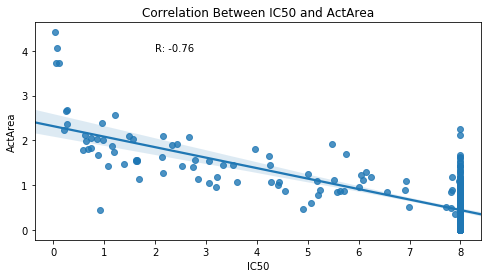

In [7]:
x = 'IC50'
y='ActArea'
plt.figure(figsize=(8, 4))
pr, _ = st.pearsonr(results[x], results[y])
sns.regplot(data=results, x=x, y=y)
plt.text(2, 4, f'R: {round(pr, 2)}')
plt.title('Correlation Between IC50 and ActArea');

## Relationship Between IC50 and Expression

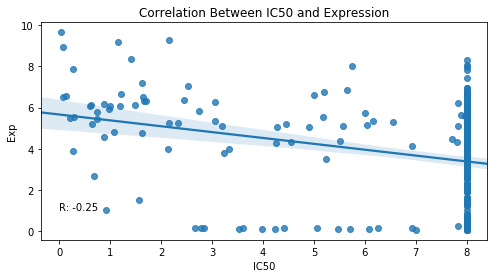

In [8]:
x = 'IC50'
y='Exp'
plt.figure(figsize=(8, 4))
pr, _ = st.pearsonr(results[x], results[y])
sns.regplot(data=results, x=x, y=y)
plt.text(0, 1, f'R: {round(pr, 2)}')
plt.title('Correlation Between IC50 and Expression');

## Expression by ActArea

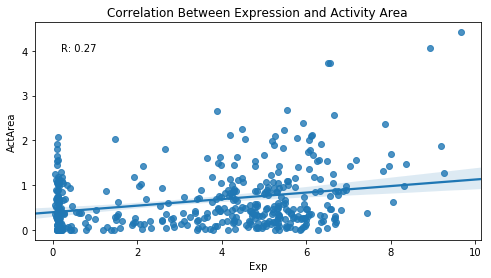

In [9]:
x = 'Exp'
y='ActArea'
plt.figure(figsize=(8, 4))
pr, _ = st.pearsonr(results[x], results[y])
sns.regplot(data=results, x=x, y=y)
plt.text(0.2, 4, f'R: {round(pr, 2)}')
plt.title('Correlation Between Expression and Activity Area');

## P-value and ActArea

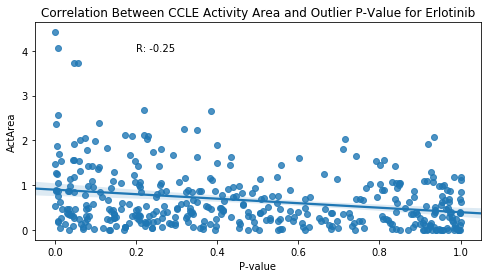

In [10]:
x = 'P-value'
y='ActArea'
plt.figure(figsize=(8, 4))
pr, _ = st.pearsonr(results[x], results[y])
sns.regplot(data=results, x=x, y=y)
plt.text(0.2, 4, f'R: {round(pr, 2)}')
plt.title('Correlation Between CCLE Activity Area and Outlier P-Value for Erlotinib');

IQR Cutoff

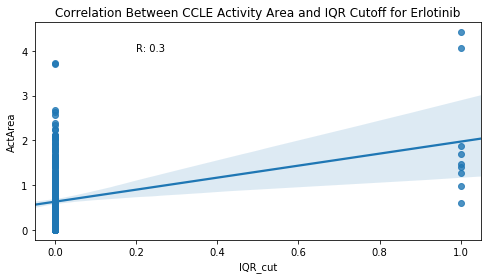

In [11]:
plt.figure(figsize=(8, 4))
sns.regplot(data=results, x='IQR_cut', y='ActArea')
pr, _ = st.pearsonr(results['IQR_cut'], results['ActArea'])
plt.text(0.2, 4, f'R: {round(pr, 2)}')
plt.title('Correlation Between CCLE Activity Area and IQR Cutoff for Erlotinib');

## P-Value and IC50

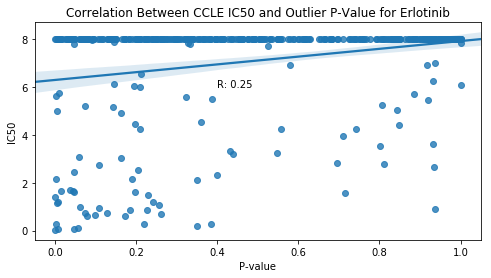

In [12]:
x = 'P-value'
y='IC50'
plt.figure(figsize=(8, 4))
pr, _ = st.pearsonr(results[x], results[y])
sns.regplot(data=results, x=x, y=y)
plt.text(0.4, 6, f'R: {round(pr, 2)}')
plt.title('Correlation Between CCLE IC50 and Outlier P-Value for Erlotinib');

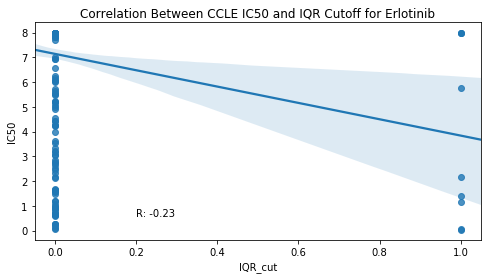

In [13]:
x = 'IQR_cut'
y ='IC50'
plt.figure(figsize=(8, 4))
pr, _ = st.pearsonr(results[x], results[y])
sns.regplot(data=results, x=x, y=y)
plt.text(0.2, 0.6, f'R: {round(pr, 2)}')
plt.title('Correlation Between CCLE IC50 and IQR Cutoff for Erlotinib');

# Expression vs. ActArea Relationships

If the ActArea isn't related to expression in a meaningful way, then it isn't a good validation experiment for an expression-based model. 

In [14]:
from collections import defaultdict

In [15]:
targets = ['MDM2', 'ALK', 'EGFR', 'CDK4']
compounds = ds[ds.Target.isin(targets)].Compound.unique()

In [16]:
# 5 columns: Compound, Target, ActArea, Expression
comps = defaultdict(list)

result_dir = '/mnt/data/expression/ccle/outlier-results'
outlier_samples = os.listdir(result_dir)

rows = []
for sample in tqdm(outlier_samples):
    # If pval.tsv does not exist, skip directory and sample
    pval_file = os.path.join(result_dir, sample, 'pvals.tsv')
    if not os.path.exists(pval_file):
        outlier_samples.remove(sample)
        continue
        
    ccle_id = met.loc[sample]['ccle_id']
    for compound in compounds:
        target = ds[ds.Compound == compound].Target.unique()[0]
        exp = ccle.loc[sample][target]
                    
        sub = ds[ds.Compound == compound]
        if not ccle_id in sub.index:
            continue
        actarea = sub.loc[ccle_id]['ActArea']

        comps['Sample'].append(sample)
        comps['Compound'].append(compound)
        comps['Target'].append(target)
        comps['ActArea'].append(actarea)
        comps['Expression'].append(exp)
comps = pd.DataFrame(comps)
comps.head()

Sample    Compound Target  ActArea  Expression
0  G27263   Erlotinib   EGFR  0.88850    0.124328
1  G27263   Lapatinib   EGFR  0.03488    0.124328
2  G27263    Nutlin-3   MDM2  0.18890    4.114367
3  G27263  PD-0332991   CDK4  0.00000    7.486634
4  G27263      TAE684    ALK  0.92990    0.014355

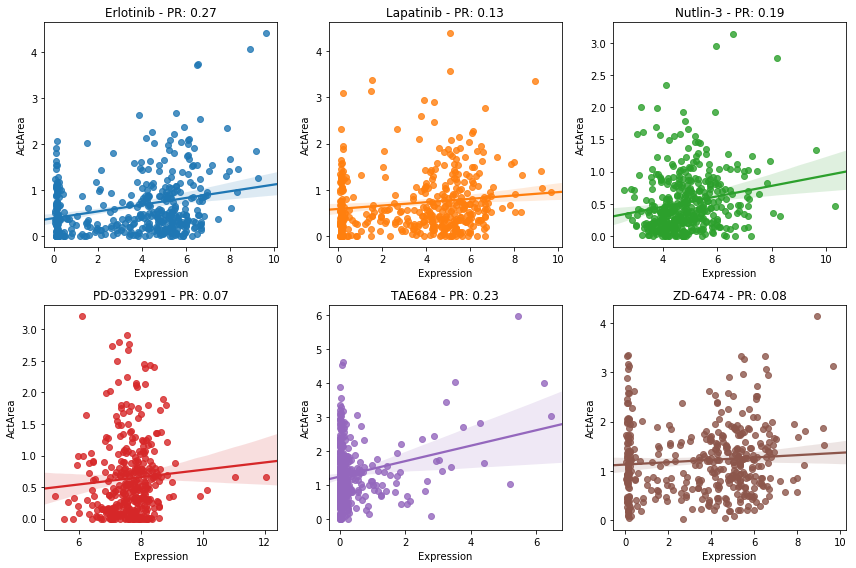

In [17]:
f, ax = plt.subplots(2, 3, figsize=(12, 8))

ax = ax.flatten()
for i, compound in enumerate(compounds):
    sub = comps[comps.Compound == compound]
    pr, _ = st.pearsonr(sub['Expression'], sub['ActArea'])
    sns.regplot(data=sub, x='Expression', y='ActArea', ax=ax[i])
    ax[i].set_title(f'{compound} - PR: {round(pr, 2)}')
plt.tight_layout()

# Examine CGP's AUC for Comparison

In [18]:
erlo = pd.read_csv('erlotinib-crx.tsv', sep='\t')
erlo.head()

Cell line TCGA classification                Tissue  \
0  NCI-H1648                LUAD                  lung   
1      TE-12                ESCA  aero_digestive_tract   
2      ECC12        UNCLASSIFIED      digestive_system   
3   BB30-HNC                HNSC  aero_digestive_tract   
4  LB996-RCC                KIRC                kidney   

             Tissue sub-type    IC50    AUC  
0  lung_NSCLC_adenocarcinoma  0.0436  0.340  
1                 oesophagus  0.0731  0.422  
2                    stomach  0.1020  0.470  
3              head_and_neck  0.1550  0.534  
4                     kidney  0.1640  0.540

In [19]:
conversion = pd.read_csv('cgp-ccle.tsv', sep='\t')
conversion = {x: y for x, y in zip(conversion['GDSC1000 name'], conversion['CCLE name'])}

In [20]:
erlo['ccle_id'] = [conversion[x] if x in conversion else np.nan for x in erlo['Cell line']]

In [21]:
erlo = erlo[pd.notna(erlo.ccle_id)]

In [22]:
results.head()

P-value  ActArea       Exp      IC50      EC50  Pval_cut  IQR_cut  \
Sample                                                                      
G27263   0.8110   0.8885  0.124328  8.000000       NaN         0        0   
G27283   0.9730   0.8777  1.275007  8.000000  8.392375         0        0   
G27271   0.2730   0.8748  4.842979  8.000000  1.583004         0        0   
G41694   0.3605   0.8709  4.331275  4.557374  3.823468         0        0   
G28535   0.3560   0.8693  4.791814  8.000000  8.226385         0        0   

        Sensitivity  Pval_correct  IQR_correct  \
Sample                                           
G27263            0             1            1   
G27283            0             1            1   
G27271            0             1            1   
G41694            0             1            1   
G28535            0             1            1   

                                         CCLE_ID  Sample  
Sample                                                    
G27263   OPM2_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE  G27263  
G27283                             TOV112D_OVARY  G27283  
G27271             42MGBA_CENTRAL_NERVOUS_SYSTEM  G27271  
G41694  HDMYZ_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE  G41694  
G28535                              OVTOKO_OVARY  G28535

In [23]:
erlo = erlo[erlo.ccle_id.isin(results['CCLE_ID'])]

In [24]:
results[results.CCLE_ID == ccle_id].Exp[0]

0.13750352374993502

In [25]:
erlo[erlo.ccle_id == ccle_id].AUC.values

array([0.992])

In [26]:
erlo_auc = defaultdict(list)
for ccle_id in erlo.ccle_id:
    erlo_auc['Exp'].append(results[results.CCLE_ID == ccle_id].Exp.values[0])
    erlo_auc['AUC'].append(erlo[erlo.ccle_id == ccle_id].AUC.values[0]) 
erlo_auc = pd.DataFrame(erlo_auc)

Text(0.5, 1.0, 'Erlotinib-CGP - PR: -0.43')

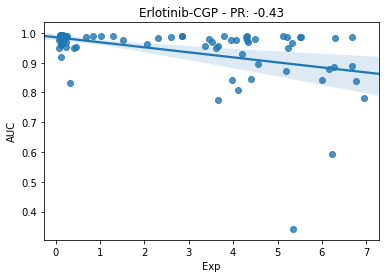

In [27]:
pr, _ = st.pearsonr(erlo_auc['Exp'], erlo_auc['AUC'])
sns.regplot(data=erlo_auc, x='Exp', y='AUC')
plt.title(f'Erlotinib-CGP - PR: {round(pr, 2)}')

# Example: G26194

In [28]:
sample = ccle.loc['G26194']
vline = hv.VLine(sample['EGFR']).options(color='red')

In [29]:
_, upper = r.math.iqr_bounds(gtex['EGFR'])
iqr = hv.VLine(upper).options(color='black', line_dash='dashed')

In [30]:
vline * iqr * gtex['EGFR'].hvplot.hist(bins=50).options(alpha=0.25, xlim=(0, 10)) \
* hv.Text(7.8, 300, 'Cutoff', halign='right') \
* hv.Text(9.5, 300, 'Sample', halign='right').options(color='red') * \
gtex[gtex.tissue == 'Cells']['EGFR'].hvplot.hist(bins=50).options(alpha=0.25)

:Overlay
   .VLine.I      :VLine   [x,y]
   .VLine.II     :VLine   [x,y]
   .Histogram.I  :Histogram   [EGFR]   (EGFR_count)
   .Text.I       :Text   [x,y]
   .Text.II      :Text   [x,y]
   .Histogram.II :Histogram   [EGFR]   (EGFR_count)

# HVPlot Regression

In [31]:
def fit_fast(grid, x, y):
    """Low-level regression and prediction using linear algebra."""
    def reg_func(_x, _y):
        return np.linalg.pinv(_x).dot(_y)

    X, y = np.c_[np.ones(len(x)), x], y
    grid = np.c_[np.ones(len(grid)), grid]
    yhat = grid.dot(reg_func(X, y))
    
    beta_boots = sns.algorithms.bootstrap(X, y, func=reg_func).T
    yhat_boots = grid.dot(beta_boots).T
    return yhat, yhat_boots

In [32]:
def regression_plot(df, x_val, y_val, vdims=None, title=None):
    # Define grid for x-axis
    xmin, xmax = df[x_val].min(), df[x_val].max()
    grid = np.linspace(xmin, xmax)
    # Seaborn Fit and CI via Bootstrapping
    yhat, yhat_boots = fit_fast(grid, df[x_val], df[y_val])
    ci = sns.utils.ci(yhat_boots, axis=0)
    # Define plot Elements
    vdims = [y_val] + vdims if vdims else [y_val]
    scatter = hv.Scatter(data=df, kdims=['P-value'], vdims=vdims).options(
        tools=['hover'], width=700, height=300, color='blue', size=5, alpha=0.50)
    regline = hv.Curve((grid, yhat)).options(color='red')
    lower = hv.Area((grid, yhat, ci[0]), vdims=['y', 'y2']).options(color='red', alpha=0.15)
    upper = hv.Area((grid, yhat, ci[1]), vdims=['y', 'y2']).options(color='red', alpha=0.15)
    
    return (scatter * regline * lower * upper).relabel(title)

In [33]:
regression_plot(results, 'P-value', 'ActArea', vdims=['Sample'])

:Overlay
   .Scatter.I :Scatter   [P-value]   (ActArea,Sample)
   .Curve.I   :Curve   [x]   (y)
   .Area.I    :Area   [x]   (y,y2)
   .Area.II   :Area   [x]   (y,y2)

# CCLE A/B Testing

## CCLE ActArea Distribution

"For each drug, cell lines with normalized activity area at least 0.8 standard deviations (SDs) above the mean were defined as sensitive to the compound, whereas those with activity area at least 0.8 SDs below the mean were defined as resistant. Cell lines with activity area within 0.8 SDs of the mean were considered to be intermediate and eliminated from our analysis"

Drug sensitivity values (activity area in CCLE) were first normalized to zero mean and unit variance across all treated cell lines. For each drug, cell lines with normalized activity area at least 0.8 standard deviations (SDs) above the mean were defined as sensitive to the compound, whereas those with activity area at least 0.8 SDs below the mean were defined as resistant. Cell lines with activity area within 0.8 SDs of the mean were considered to be intermediate and eliminated from our analysis

In [34]:
std = erlotinib.ActArea.std()
erlotinib.ActArea.hvplot.kde() * \
hv.VLine(erlotinib.ActArea.mean(), label='Mean') * \
hv.VLine(erlotinib.ActArea.mean() + std, group='+1 STD').options(color='red') * \
hv.Text(1.3, 0.6, 'Sensitivity\nCutoff', halign='left')

:Overlay
   .Distribution.I :Distribution   [ActArea]   (Density)
   .VLine.Mean     :VLine   [x,y]
   .Plus_1_STD.I   :VLine   [x,y]
   .Text.I         :Text   [x,y]

## CCLE A/B Testing 

Extract correct sensitivity calls

In [35]:
correct = results[results.Sensitivity == 1]
n = len(correct)

In [36]:
results['Sensitivity'].value_counts()

0    350
1     60
Name: Sensitivity, dtype: int64

In [37]:
results[['Pval_correct', 'IQR_correct']].sum() / len(results)

Pval_correct    0.756098
IQR_correct     0.865854
dtype: float64

In [38]:
correct[['Pval_correct', 'IQR_correct']].sum() / len(correct)

Pval_correct    0.450000
IQR_correct     0.116667
dtype: float64

In [39]:
with pm.Model() as model:
    prior_pval = pm.Beta('pval-prior', alpha=2, beta=2)
    prior_iqr = pm.Beta('pval-iqr', alpha=2, beta=2)
    
    like_pval = pm.Binomial('like-pval', n=n, p=prior_pval, observed=correct['Pval_correct'])
    like_iqr = pm.Binomial('like-iqr', n=n, p=prior_iqr, observed=correct['IQR_correct'])
       
    diff = pm.Deterministic('Diff', prior_pval - prior_iqr)
    relation = pm.Deterministic('Relation', (prior_pval / prior_iqr) - 1)
    
    trace = pm.sample(draws=10_000, tune=1_000)

INFO (theano.gof.compilelock): Waiting for existing lock by process '16568' (I am process '17277')
INFO:theano.gof.compilelock:Waiting for existing lock by process '16568' (I am process '17277')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir
INFO:theano.gof.compilelock:To manually release the lock, delete /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '16568' (I am process '17277')
INFO:theano.gof.compilelock:Waiting for existing lock by process '16568' (I am process '17277')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir
INFO:theano.gof.compilelock:To manually release the lock, delete /home/ubuntu/.theano/co

The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')

The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')

The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')

The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')



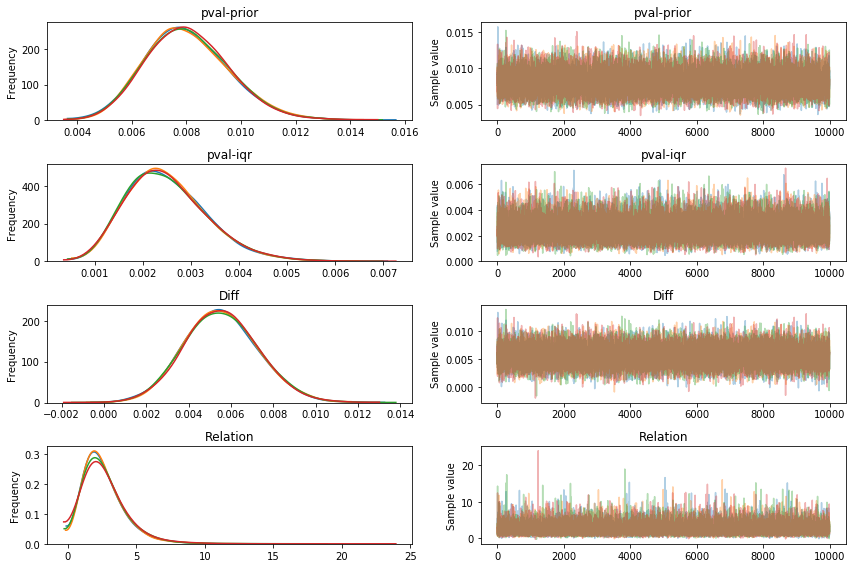

In [40]:
pm.traceplot(trace);

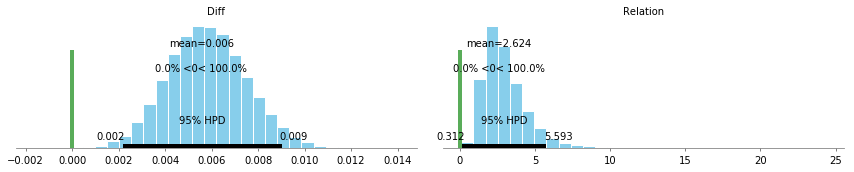

In [41]:
pm.plot_posterior(trace, varnames=['Diff', 'Relation'], ref_val=0);